# Plotting upper ocean heat content

In [1]:
import cosima_cookbook as cc
from dask.distributed import Client

import xarray as xr
import matplotlib.pyplot as plt
import cmocean as cm
import numpy as np
%matplotlib inline

# Stop annoying warnings coming out of xarray.
import warnings
warnings.filterwarnings('ignore')

In [2]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 28,Total memory: 125.20 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39919,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 125.20 GiB
Comm: tcp://127.0.0.1:33875,Total threads: 4
Dashboard: /proxy/39787/status,Memory: 17.89 GiB
Nanny: tcp://127.0.0.1:44415,


In [3]:
session_CM2  = cc.database.create_session('/g/data/p73/archive/non-CMIP/ACCESS-CM2/CM2.db')
expt_CM2_025 = 'cj877'
expt_CM2_1   = 'bz687'

In [4]:
# OM2 database
session_OM2  = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
expt_OM2_025 = '025deg_jra55_ryf9091_gadi'
expt_OM2_1   = '1deg_jra55_ryf9091_gadi'

If you get a 'read-only database' warning, it is because the database has not finished building. 

In [7]:
path_to_data = '/g/data/x77/wgh581/Post_Process/ACCESS_CM2_025/'
fig_path = '/g/data/x77/wgh581/Figures/Figures_ACCESS_CM2/'

In [6]:
# Plotting info
ft_size = 16
plt.rcParams.update({'font.size': ft_size})

### I. Heat content calculation (skip to II. if done already)

$$ HC = \rho_0 c_p \int_{-50 m}^\eta T dz $$

$\rho_0 = 1035.0 $ kg m$^{−3}$ mean density of seawater

$c_p = 3992.1 $ J K$^{−1}$ kg$^{−1}$ specific heat capacity of seawater

Code below is based on [Navid's code](https://github.com/navidcy/IntrinsicOceanicLFVariabilityUOHC/blob/master/prepare-raw-data.ipynb) 

In [7]:
rho0 = 1035.0
cp   = 3992.1

In [8]:
def get_OHC(expt, session, top=0, bottom=50, start_time='0001-01-01', end_time='0001-12-31', frequency='1 monthly'):
    
    temp = cc.querying.getvar(expt, 'temp', session, start_time=start_time, end_time=end_time, frequency=frequency) # in K
    temp = temp.sel(time=slice(start_time, end_time))
    
    # Find actual depth of cells closest to top and bottom values
    Lz = np.max(temp.sel(st_ocean=slice(top, bottom)).st_ocean.values) - np.min(temp.sel(st_ocean=slice(top, bottom)).st_ocean.values)
    
    # Grid depth
    requested_depth = bottom - top # Navid had top-bottom but that gives -ve values
    grid_depth = (1 + 0*temp.isel(time=0).sel({'xt_ocean': -40, 'yt_ocean': 40}, method='nearest')).sel(st_ocean=slice(top, bottom)).integrate('st_ocean').values
    
    # Normalisation for depth
    normalisation_for_depth = requested_depth / grid_depth
    
    # Calculate ocean heat content
    UOHC = (normalisation_for_depth * rho0 * cp * temp).sel(st_ocean=slice(top, bottom)).integrate('st_ocean')
    UOHC = UOHC.groupby('time.year').mean(dim='time')
    UOHC = UOHC.rename("uohc")
    #UOHC = UOHC.chunk({"time": 12})
    UOHC.attrs["long_name"] = "Upper ocean heat content; depth-integrated from "+str(bottom)+"m to "+str(top)+"m"
    UOHC.attrs["units"] = "Joules meters**-2"
    
    return UOHC.compute()

# .resample(time='Y').mean()
# .groupby('time.year').mean(dim='time')

CM2-025

In [ ]:
%%time
uohc = get_OHC(expt_CM2_025, session_CM2, start_time='0400-01-01', end_time='0499-12-31')

In [10]:
uohc.to_netcdf(path_to_data + '/uohc_annual_400_500.nc')

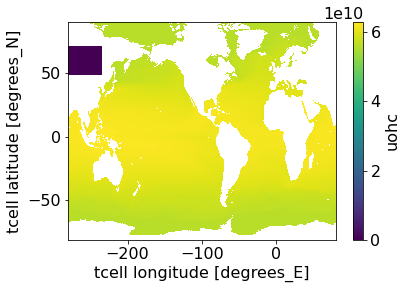

In [55]:
test_ohc.mean('year').plot()

CM2-1

In [17]:
%%time
year_start = ['0001', '0100', '0200', '0300', '0400']
year_end   = ['0099', '0199', '0299', '0399', '0499']
for ii in range(5):
    start_time = year_start[ii] + '-01-01'
    end_time   = year_end[ii] + '-12-31'
    uohc = get_OHC(expt_CM2_1, session_CM2, start_time=start_time, end_time=end_time)
    uohc.to_netcdf(path_to_data + 'Comparison_ACCESS_CM2_1/uohc_annual_CM2_1_%s_%s.nc'%(year_start[ii], year_end[ii]))
    print('Saved: ', path_to_data + 'Comparison_ACCESS_CM2_1/uohc_annual_CM2_1_%s_%s.nc'%(year_start[ii], year_end[ii]))

Saved:  /g/data/x77/wgh581/Post_Process/ACCESS_CM2_025/Comparison_ACCESS_CM2_1/uohc_annual_CM2_1_0001_0099.nc
Saved:  /g/data/x77/wgh581/Post_Process/ACCESS_CM2_025/Comparison_ACCESS_CM2_1/uohc_annual_CM2_1_0100_0199.nc
Saved:  /g/data/x77/wgh581/Post_Process/ACCESS_CM2_025/Comparison_ACCESS_CM2_1/uohc_annual_CM2_1_0200_0299.nc
Saved:  /g/data/x77/wgh581/Post_Process/ACCESS_CM2_025/Comparison_ACCESS_CM2_1/uohc_annual_CM2_1_0300_0399.nc
Saved:  /g/data/x77/wgh581/Post_Process/ACCESS_CM2_025/Comparison_ACCESS_CM2_1/uohc_annual_CM2_1_0400_0499.nc
CPU times: user 8min 45s, sys: 35.1 s, total: 9min 20s
Wall time: 22min 22s


OM2-025

In [ ]:
%%time
# year_start = ['1904', '0100', '0200', '0300', '0400']
# year_end   = ['1999', '0199', '0299', '0399', '0499']
# for ii in range(5):
#     start_time = year_start[ii] + '-01-01'
#     end_time   = year_end[ii] + '-12-31'
#     uohc = get_OHC(expt_OM2_025, session_OM2, start_time=start_time, end_time=end_time)
#     uohc.to_netcdf(path_to_data + 'Comparison_ACCESS_OM2_025/uohc_annual_OM2_025_%s_%s.nc'%(year_start[ii], year_end[ii]))
#     print('Saved: ', path_to_data + 'Comparison_ACCESS_OM2_025/uohc_annual_OM2_025_%s_%s.nc'%(year_start[ii], year_end[ii]))

uohc = get_OHC(expt_OM2_025, session_OM2, start_time='1904-01-01', end_time='2299-12-31', frequency='1 yearly')
uohc.to_netcdf(path_to_data + 'Comparison_ACCESS_OM2_025/uohc_annual_OM2_025_1904_2299.nc')

In [ ]:
%%time 
uohc = get_OHC(expt_OM2_025, session_OM2, start_time='2300-01-01', end_time='2399-12-31')
uohc.to_netcdf(path_to_data + 'Comparison_ACCESS_OM2_025/uohc_annual_OM2_025_2300_2399.nc')

In [26]:
%%time 
uohc = get_OHC(expt_OM2_025, session_OM2, start_time='1900-01-01', end_time='1903-12-31')
uohc.to_netcdf(path_to_data + 'Comparison_ACCESS_OM2_025/uohc_annual_OM2_025_1900_1903.nc')

CPU times: user 9.2 s, sys: 632 ms, total: 9.83 s
Wall time: 13.2 s


OM2-1

In [ ]:
%%time
uohc = get_OHC(expt_OM2_1, session_OM2, start_time='1904-01-01', end_time='2299-12-31', frequency='1 yearly')
uohc.to_netcdf(path_to_data + 'Comparison_ACCESS_OM2_1/uohc_annual_OM2_1_1904_2299.nc')

In [ ]:
# %%time 
# uohc = get_OHC(expt_OM2_1, session_OM2, start_time='2300-01-01', end_time='2301-12-31')
# #uohc.to_netcdf(path_to_data + 'Comparison_ACCESS_OM2_1/uohc_annual_OM2_1_2300_2399.nc')

Concat individual files

In [ ]:
# # CM2-025
# # Load, concatenate and save individual time series
# data1 = xr.open_dataarray(path_to_data + 'uohc_annual_0_100.nc')
# data2 = xr.open_dataarray(path_to_data + 'uohc_annual_100_200.nc')
# data3 = xr.open_dataarray(path_to_data + 'uohc_annual_200_300.nc')
# data4 = xr.open_dataarray(path_to_data + 'uohc_annual_300_400.nc')
# data5 = xr.open_dataarray(path_to_data + 'uohc_annual_400_500.nc')

In [15]:
# data = xr.concat([data1, data2, data3, data4, data5], dim="year")

In [17]:
# data.to_netcdf(path_to_data + 'uohc_annual.nc')

In [14]:
# CM2-1
data1 = xr.open_dataarray(path_to_data + 'Comparison_ACCESS_CM2_1/uohc_annual_CM2_1_0001_0099.nc')
data2 = xr.open_dataarray(path_to_data + 'Comparison_ACCESS_CM2_1/uohc_annual_CM2_1_0100_0199.nc')
data3 = xr.open_dataarray(path_to_data + 'Comparison_ACCESS_CM2_1/uohc_annual_CM2_1_0200_0299.nc')
data4 = xr.open_dataarray(path_to_data + 'Comparison_ACCESS_CM2_1/uohc_annual_CM2_1_0300_0399.nc')
data5 = xr.open_dataarray(path_to_data + 'Comparison_ACCESS_CM2_1/uohc_annual_CM2_1_0400_0499.nc')

In [16]:
data = xr.concat([data1, data2, data3, data4, data5], dim="year")
data.to_netcdf(path_to_data + 'Comparison_ACCESS_CM2_1/uohc_annual_CM2_1.nc')

In [18]:
# OM2-025
data1 = xr.open_dataarray(path_to_data + 'Comparison_ACCESS_OM2_025/uohc_annual_OM2_025_1900_1903.nc')
data2 = xr.open_dataarray(path_to_data + 'Comparison_ACCESS_OM2_025/uohc_annual_OM2_025_1904_2299.nc')
data3 = xr.open_dataarray(path_to_data + 'Comparison_ACCESS_OM2_025/uohc_annual_OM2_025_2300_2399.nc')

In [22]:
#data = xr.concat([data1, data2, data3], dim="year")
data.to_netcdf(path_to_data + 'Comparison_ACCESS_OM2_025/uohc_annual_OM2_025.nc')

In [23]:
# OM2-1
# Still need to load remaining years (got an error message previously, didn't follow-up on it)

### II. Integrate in space and plot time series

Load previously extracted upper ocean heat content

In [8]:
uohc_CM2_025 = xr.open_dataarray(path_to_data + 'uohc_annual.nc')
uohc_OM2_025 = xr.open_dataarray(path_to_data + 'Comparison_ACCESS_OM2_025/uohc_annual_OM2_025.nc')
uohc_OM2_1   = xr.open_dataarray(path_to_data + 'Comparison_ACCESS_OM2_1/uohc_annual_OM2_1_1904_2299.nc')
uohc_CM2_1   = xr.open_dataarray(path_to_data + 'Comparison_ACCESS_CM2_1/uohc_annual_CM2_1.nc')

In [23]:
uohc_CM2_025

<xarray.DataArray 'uohc' (year: 499, yt_ocean: 1080, xt_ocean: 1440)>
[776044800 values with dtype=float64]
Coordinates:
  * xt_ocean  (xt_ocean) float64 -279.9 -279.6 -279.4 ... 79.38 79.62 79.88
  * yt_ocean  (yt_ocean) float64 -81.08 -80.97 -80.87 ... 89.74 89.84 89.95
  * year      (year) int64 1 2 3 4 5 6 7 8 9 ... 492 493 494 495 496 497 498 499
Attributes:
    long_name:  Upper ocean heat content; depth-integrated from 50m to 0m
    units:      Joules meters**-2

Load grid cell area

In [9]:
area_CM2_025 = cc.querying.getvar(expt_CM2_025, 'area_t', session_CM2, n=1)
area_CM2_1   = cc.querying.getvar(expt_CM2_1, 'area_t', session_CM2, n=1)
area_OM2_025 = cc.querying.getvar(expt_OM2_025, 'area_t', session_OM2, n=1)
area_OM2_1   = cc.querying.getvar(expt_OM2_1, 'area_t', session_OM2, n=1)

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, cal

Area does not have the same mask as the uohc data, fixing that now

In [10]:
area_CM2_025 = uohc_CM2_025[0,:,:]/uohc_CM2_025[0,:,:]*area_CM2_025
area_CM2_1   = uohc_CM2_1[0,:,:]/uohc_CM2_1[0,:,:]*area_CM2_1
area_OM2_025 = uohc_OM2_025[0,:,:]/uohc_OM2_025[0,:,:]*area_OM2_025
area_OM2_1   = uohc_OM2_1[0,:,:]/uohc_OM2_1[0,:,:]*area_OM2_1

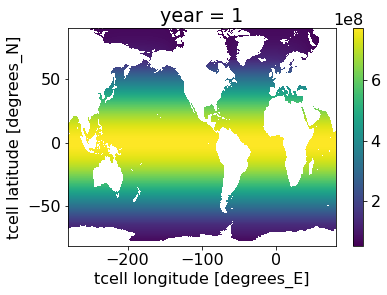

In [11]:
area_CM2_025.plot()

#### North Atlantic

In [29]:
lat_slice = slice(40,65)
lon_slice = slice(-99,25)

In [30]:
%%time
var = uohc_CM2_025.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice) * area_CM2_025.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
uohc_CM2_025_NA = var.sum('xt_ocean').sum('yt_ocean').compute()

var = uohc_OM2_025.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice) * area_OM2_025.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
uohc_OM2_025_NA = var.sum('xt_ocean').sum('yt_ocean').compute()

var = uohc_OM2_1.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice) * area_OM2_1.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
uohc_OM2_1_NA = var.sum('xt_ocean').sum('yt_ocean').compute()

var = uohc_CM2_1.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice) * area_CM2_1.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
uohc_CM2_1_NA = var.sum('xt_ocean').sum('yt_ocean').compute()

# in J

CPU times: user 2.06 s, sys: 1.46 s, total: 3.52 s
Wall time: 6.35 s


The total area is resolution-dependent, hence we need to normalise the total heat content by dividing by the total area.

In [31]:
uohc_CM2_025_NA_norm = uohc_CM2_025_NA / area_CM2_025.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice).sum('xt_ocean').sum('yt_ocean')
uohc_CM2_1_NA_norm   = uohc_CM2_1_NA / area_CM2_1.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice).sum('xt_ocean').sum('yt_ocean')
uohc_OM2_025_NA_norm = uohc_OM2_025_NA / area_OM2_025.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice).sum('xt_ocean').sum('yt_ocean')
uohc_OM2_1_NA_norm   = uohc_OM2_1_NA / area_OM2_1.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice).sum('xt_ocean').sum('yt_ocean')

# in J/m2

In [15]:
print('CM2-025:', area_CM2_025.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice).sum('xt_ocean').sum('yt_ocean').values)
print('OM2-025:', area_OM2_025.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice).sum('xt_ocean').sum('yt_ocean').values)
print('CM2-1:', area_CM2_1.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice).sum('xt_ocean').sum('yt_ocean').values)
print('OM2-1:', area_OM2_1.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice).sum('xt_ocean').sum('yt_ocean').values)

CM2-025: 12610562351840.0
OM2-025: 12539696439232.0
CM2-1: 13834118766080.0
OM2-1: 13834118766080.0


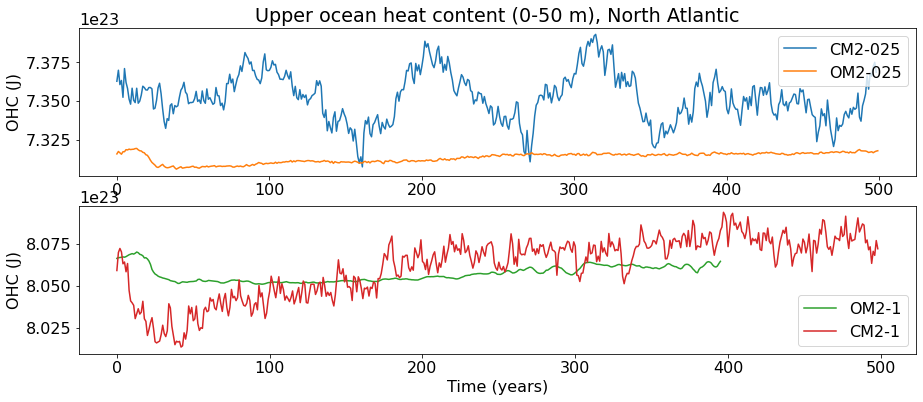

In [23]:
fig = plt.figure(figsize=(15,6))

plt.subplot(211)
plt.title('Upper ocean heat content (0-50 m), North Atlantic')
plt.plot(uohc_CM2_025_NA, label='CM2-025')
plt.plot(uohc_OM2_025_NA, label='OM2-025')
plt.legend()
plt.ylabel('OHC (J)')

plt.subplot(212)
plt.plot(uohc_OM2_1_NA, color='C2', label='OM2-1')
plt.plot(uohc_CM2_1_NA, color='C3', label='CM2-1')
plt.legend()

plt.xlabel('Time (years)')
plt.ylabel('OHC (J)');

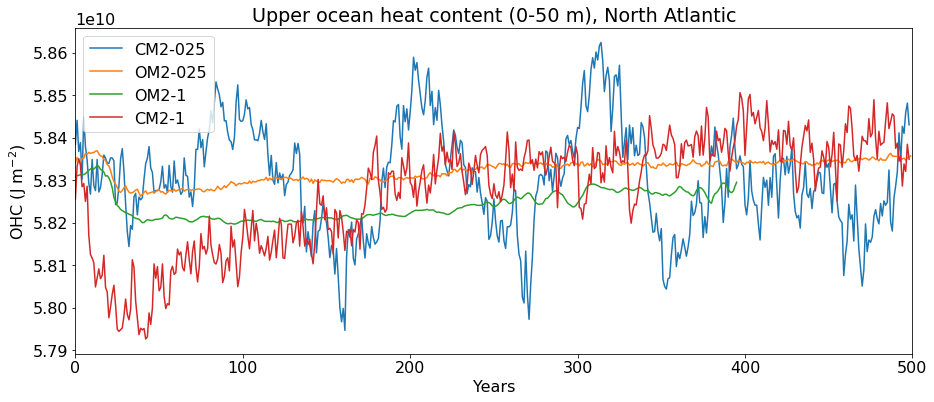

In [32]:
fig = plt.figure(figsize=(15,6))

plt.subplot(111)
plt.title('Upper ocean heat content (0-50 m), North Atlantic')
plt.plot(uohc_CM2_025_NA_norm, label='CM2-025')
plt.plot(uohc_OM2_025_NA_norm, label='OM2-025')
plt.plot(uohc_OM2_1_NA_norm, color='C2', label='OM2-1')
plt.plot(uohc_CM2_1_NA_norm, color='C3', label='CM2-1')
plt.legend()
plt.xlim(0, 500)

plt.xlabel('Years')
plt.ylabel('OHC (J m$^{-2}$)') # normed by total area

# Finished
save_flag = 1
if save_flag == 1:
    fig_name = 'Fig_uohc_NA_annual.png'
    plt.savefig(fig_path + fig_name);

#### Southern Ocean

In [11]:
lat_slice = slice(-90,-34)

In [12]:
%%time
var = uohc_CM2_025.sel(yt_ocean=lat_slice) * area_CM2_025.sel(yt_ocean=lat_slice)
uohc_CM2_025_SO = var.sum('xt_ocean').sum('yt_ocean').compute()

var = uohc_OM2_025.sel(yt_ocean=lat_slice) * area_OM2_025.sel(yt_ocean=lat_slice)
uohc_OM2_025_SO = var.sum('xt_ocean').sum('yt_ocean').compute()

var = uohc_OM2_1.sel(yt_ocean=lat_slice) * area_OM2_1.sel(yt_ocean=lat_slice)
uohc_OM2_1_SO = var.sum('xt_ocean').sum('yt_ocean').compute()

var = uohc_CM2_1.sel(yt_ocean=lat_slice) * area_CM2_1.sel(yt_ocean=lat_slice)
uohc_CM2_1_SO = var.sum('xt_ocean').sum('yt_ocean').compute()

CPU times: user 10.1 s, sys: 12.6 s, total: 22.7 s
Wall time: 1min 1s


In [13]:
uohc_CM2_025_SO_norm = uohc_CM2_025_SO / area_CM2_025.sel(yt_ocean=lat_slice).sum('xt_ocean').sum('yt_ocean')
uohc_CM2_1_SO_norm   = uohc_CM2_1_SO / area_CM2_1.sel(yt_ocean=lat_slice).sum('xt_ocean').sum('yt_ocean')
uohc_OM2_025_SO_norm = uohc_OM2_025_SO / area_OM2_025.sel(yt_ocean=lat_slice).sum('xt_ocean').sum('yt_ocean')
uohc_OM2_1_SO_norm   = uohc_OM2_1_SO / area_OM2_1.sel(yt_ocean=lat_slice).sum('xt_ocean').sum('yt_ocean')

# in J/m2

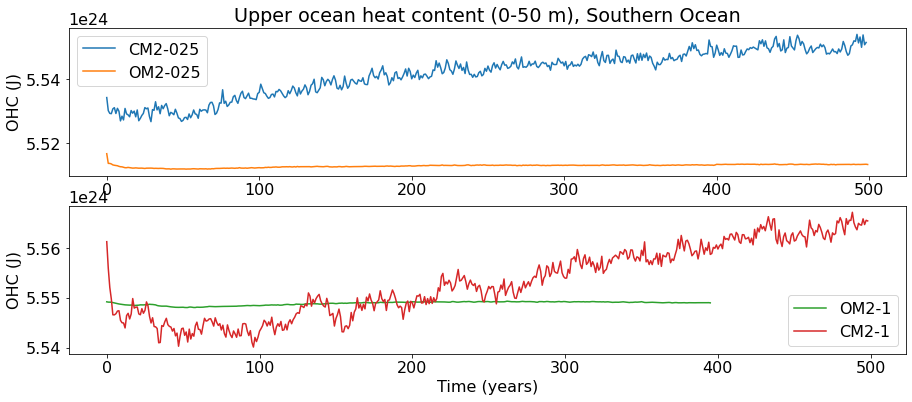

In [27]:
fig = plt.figure(figsize=(15,6))

plt.subplot(211)
plt.title('Upper ocean heat content (0-50 m), Southern Ocean')
plt.plot(uohc_CM2_025_SO, label='CM2-025')
plt.plot(uohc_OM2_025_SO, label='OM2-025')
plt.legend()
plt.ylabel('OHC (J)')

plt.subplot(212)
plt.plot(uohc_OM2_1_SO, color='C2', label='OM2-1')
plt.plot(uohc_CM2_1_SO, color='C3', label='CM2-1')
plt.legend()

plt.xlabel('Time (years)')
plt.ylabel('OHC (J)');

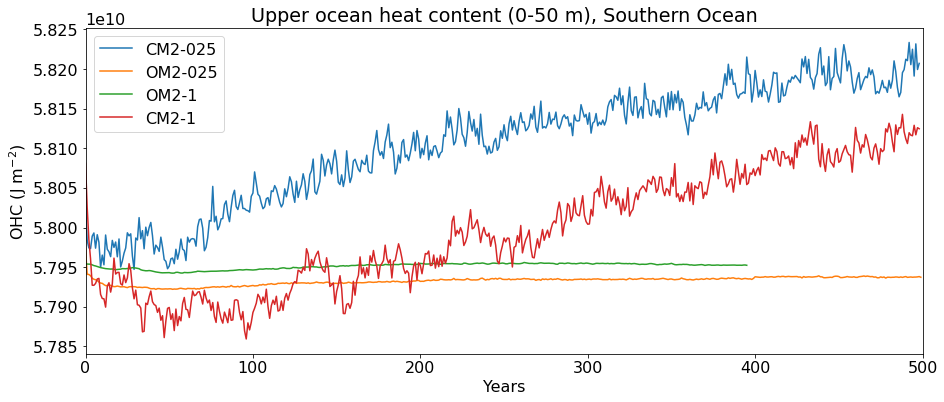

In [33]:
fig = plt.figure(figsize=(15,6))

plt.subplot(111)
plt.title('Upper ocean heat content (0-50 m), Southern Ocean')
plt.plot(uohc_CM2_025_SO_norm, label='CM2-025')
plt.plot(uohc_OM2_025_SO_norm, label='OM2-025')
plt.plot(uohc_OM2_1_SO_norm, color='C2', label='OM2-1')
plt.plot(uohc_CM2_1_SO_norm, color='C3', label='CM2-1')
plt.legend()
plt.xlim(0, 500)

plt.xlabel('Years')
plt.ylabel('OHC (J m$^{-2}$)') # normed by total area

# Finished
save_flag = 1
if save_flag == 1:
    fig_name = 'Fig_uohc_SO_annual.png'
    plt.savefig(fig_path + fig_name);

#### North Pacific

In [16]:
lat_slice = slice(40, 65)
lon_slice = slice(-235, -120)

In [17]:
%%time
var = uohc_CM2_025.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice) * area_CM2_025.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
uohc_CM2_025_NP = var.sum('xt_ocean').sum('yt_ocean').compute()

var = uohc_OM2_025.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice) * area_OM2_025.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
uohc_OM2_025_NP = var.sum('xt_ocean').sum('yt_ocean').compute()

var = uohc_OM2_1.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice) * area_OM2_1.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
uohc_OM2_1_NP = var.sum('xt_ocean').sum('yt_ocean').compute()

var = uohc_CM2_1.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice) * area_CM2_1.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
uohc_CM2_1_NP = var.sum('xt_ocean').sum('yt_ocean').compute()

CPU times: user 4.45 s, sys: 4.71 s, total: 9.16 s
Wall time: 35.3 s


In [18]:
uohc_CM2_025_NP_norm = uohc_CM2_025_NP / area_CM2_025.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice).sum('xt_ocean').sum('yt_ocean')
uohc_CM2_1_NP_norm   = uohc_CM2_1_NP / area_CM2_1.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice).sum('xt_ocean').sum('yt_ocean')
uohc_OM2_025_NP_norm = uohc_OM2_025_NP / area_OM2_025.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice).sum('xt_ocean').sum('yt_ocean')
uohc_OM2_1_NP_norm   = uohc_OM2_1_NP / area_OM2_1.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice).sum('xt_ocean').sum('yt_ocean')

# in J/m2

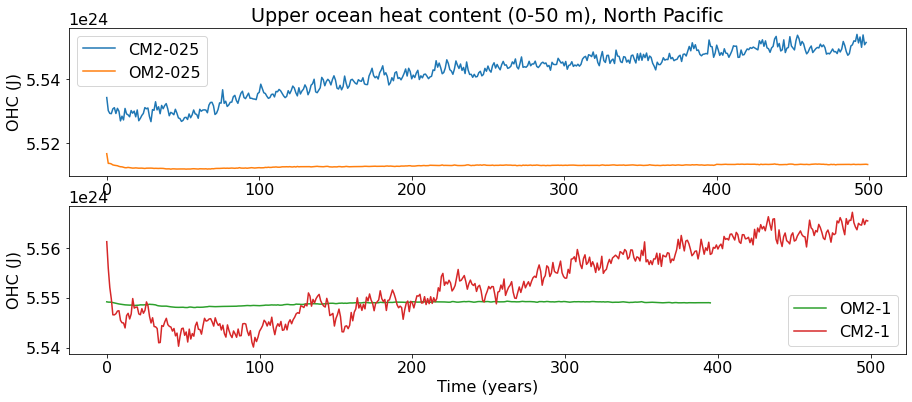

In [26]:
fig = plt.figure(figsize=(15,6))

plt.subplot(211)
plt.title('Upper ocean heat content (0-50 m), North Pacific')
plt.plot(uohc_CM2_025_SO, label='CM2-025')
plt.plot(uohc_OM2_025_SO, label='OM2-025')
plt.legend()
plt.ylabel('OHC (J)')

plt.subplot(212)
plt.plot(uohc_OM2_1_SO, color='C2', label='OM2-1')
plt.plot(uohc_CM2_1_SO, color='C3', label='CM2-1')
plt.legend()

plt.xlabel('Time (years)')
plt.ylabel('OHC (J)');

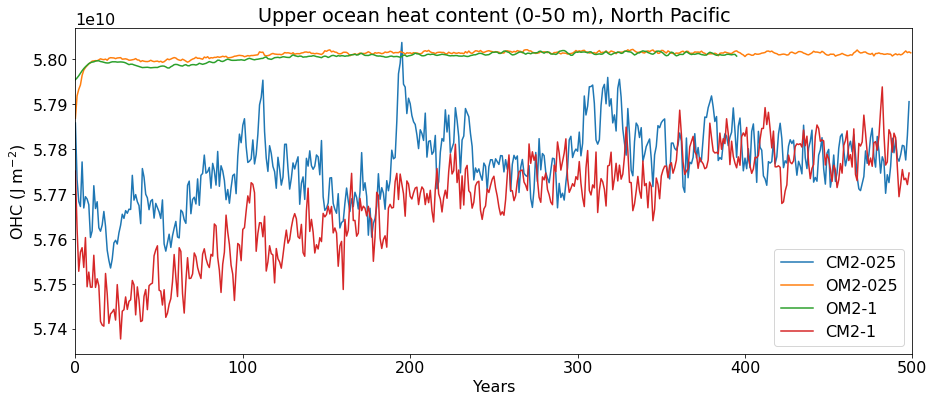

In [34]:
fig = plt.figure(figsize=(15,6))

plt.subplot(111)
plt.title('Upper ocean heat content (0-50 m), North Pacific')
plt.plot(uohc_CM2_025_NP_norm, label='CM2-025')
plt.plot(uohc_OM2_025_NP_norm, label='OM2-025')
plt.plot(uohc_OM2_1_NP_norm, color='C2', label='OM2-1')
plt.plot(uohc_CM2_1_NP_norm, color='C3', label='CM2-1')
plt.legend()
plt.xlim(0, 500)

plt.xlabel('Years')
plt.ylabel('OHC (J m$^{-2}$)') # normed by total area

# Finished
save_flag = 1
if save_flag == 1:
    fig_name = 'Fig_uohc_NP_annual.png'
    plt.savefig(fig_path + fig_name);

#### Global

In [21]:
lat_slice = slice(-90, 65)

In [22]:
%%time
var = uohc_CM2_025.sel(yt_ocean=lat_slice) * area_CM2_025.sel(yt_ocean=lat_slice)
uohc_CM2_025_global = var.sum('xt_ocean').sum('yt_ocean').compute()

var = uohc_OM2_025.sel(yt_ocean=lat_slice) * area_OM2_025.sel(yt_ocean=lat_slice)
uohc_OM2_025_global = var.sum('xt_ocean').sum('yt_ocean').compute()

var = uohc_OM2_1.sel(yt_ocean=lat_slice) * area_OM2_1.sel(yt_ocean=lat_slice)
uohc_OM2_1_global = var.sum('xt_ocean').sum('yt_ocean').compute()

var = uohc_CM2_1.sel(yt_ocean=lat_slice) * area_CM2_1.sel(yt_ocean=lat_slice)
uohc_CM2_1_global = var.sum('xt_ocean').sum('yt_ocean').compute()

2022-08-31 18:11:23,728 - distributed.worker_memory - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memory: 14.66 GiB -- Worker memory limit: 17.89 GiB
2022-08-31 18:11:25,420 - distributed.worker_memory - WARNING - Worker is at 52% memory usage. Resuming worker. Process memory: 9.33 GiB -- Worker memory limit: 17.89 GiB


CPU times: user 22 s, sys: 22.9 s, total: 44.9 s
Wall time: 1min 42s


In [23]:
uohc_CM2_025_global_norm = uohc_CM2_025_global / area_CM2_025.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice).sum('xt_ocean').sum('yt_ocean')
uohc_CM2_1_global_norm   = uohc_CM2_1_global / area_CM2_1.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice).sum('xt_ocean').sum('yt_ocean')
uohc_OM2_025_global_norm = uohc_OM2_025_global / area_OM2_025.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice).sum('xt_ocean').sum('yt_ocean')
uohc_OM2_1_global_norm   = uohc_OM2_1_global / area_OM2_1.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice).sum('xt_ocean').sum('yt_ocean')

# in J/m2

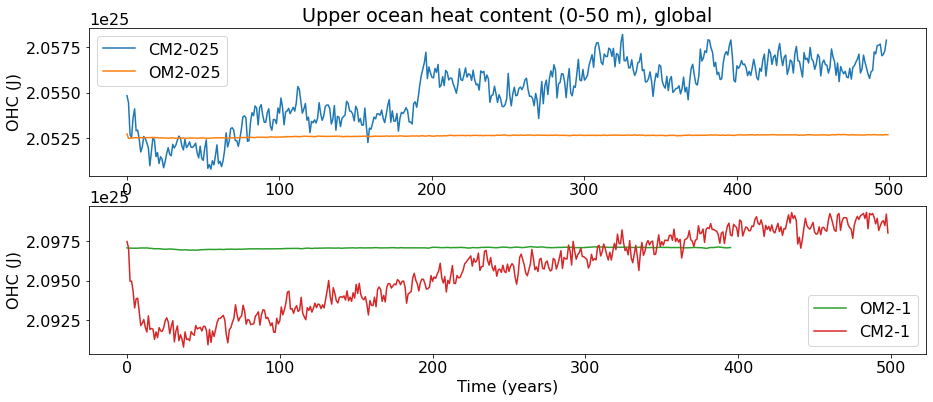

In [24]:
fig = plt.figure(figsize=(15,6))

plt.subplot(211)
plt.title('Upper ocean heat content (0-50 m), global')
plt.plot(uohc_CM2_025_global, label='CM2-025')
plt.plot(uohc_OM2_025_global, label='OM2-025')
plt.legend()
plt.ylabel('OHC (J)')

plt.subplot(212)
plt.plot(uohc_OM2_1_global, color='C2', label='OM2-1')
plt.plot(uohc_CM2_1_global, color='C3', label='CM2-1')
plt.legend()

plt.xlabel('Time (years)')
plt.ylabel('OHC (J)');

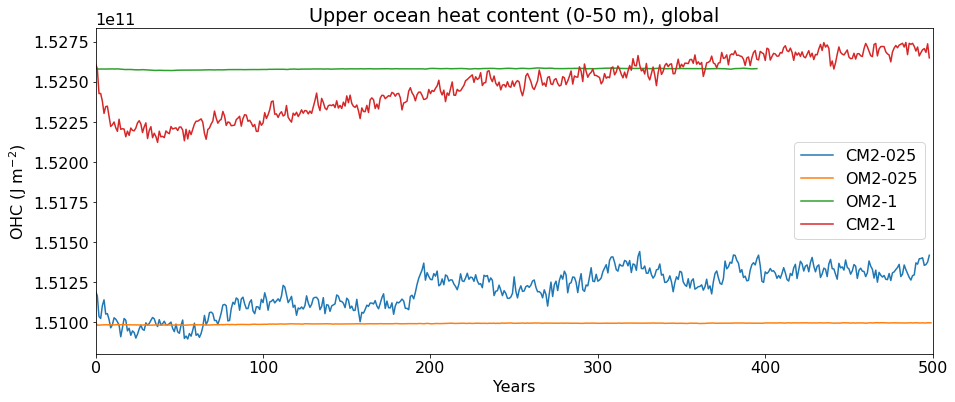

In [35]:
fig = plt.figure(figsize=(15,6))

plt.subplot(111)
plt.title('Upper ocean heat content (0-50 m), global')
plt.plot(uohc_CM2_025_global_norm, label='CM2-025')
plt.plot(uohc_OM2_025_global_norm, label='OM2-025')
plt.plot(uohc_OM2_1_global_norm, color='C2', label='OM2-1')
plt.plot(uohc_CM2_1_global_norm, color='C3', label='CM2-1')
plt.legend()
plt.xlim(0, 500)

plt.xlabel('Years')
plt.ylabel('OHC (J m$^{-2}$)') # normed by total area

# Finished
save_flag = 1
if save_flag == 1:
    fig_name = 'Fig_uohc_global_annual.png'
    plt.savefig(fig_path + fig_name);